# Supervised simple classifier ablation and parameter sweep

This notebook does a more rigorous evaluation of the "simple classifier" model on prelabled Rainfall data for OCaml. The goal is to evaluate the impact of different data preprocessing decisions on accuracy (ablation), as well as to determine the best set of parameters.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
from autoplan.trainer import ClassifierTrainer, option_combinations
from autoplan.dataset import PrelabeledDataset
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.token import TokenType
from scripts.rainfall_ingest import ingest_dataset

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torch
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda:0')
REPO_DIR = os.path.expanduser('~/autoplan')

## Data preprocessing ablation

### Motivation

In preparing the program for processing by the neural network, a general goal is to eliminate "unnecessary" variation in the student programs. For example, whether a student names a variable x vs y, or whether a student has 5 unit tests vs. 10 we know to be unrelated to the core task of classifying structure. 

One possibility is to hope that the neural network automatically learns to identify only the relevant variation to classifying structure, but with the small size of the training set, we hypothesize that reducing variation can help accuracy.

We have two possible filtering steps to apply: first is to anonymize certain classes of tokens (`exclude`). By default, the variables x and y are treated as different tokens and assigned a unique and unrelated ID, so theoretically the network has to separately learn how to interpret the two variables. Similarly for numbers and strings. Anonymizing these tokens means mapping all tokens of the same class (e.g. all identifiers, all strings) to the same number.

The second step is to eliminate all top-level statements that are not function definitions (`preprocess`). In OCaml, this eliminates imports and top-level unit tests. This step requires parsing the program into a syntax tree, which means re-exporting the syntax tree back into a source text that can then be tokenized. It's worth noting that the original syntax is not perfectly preserved, e.g. extra parentheses are inserted and type annotations are reordered (so this too "normalizes" the syntax to some extent).

### Experiment

In this experiment, we compute every combination of the two options as shown below, construct the appropriate datasets, and then cross-validate a model with default parameters on each dataset. For cross-validation, we randomly partition the labeled data into 2/3 train and 1/3 test K=10 times, and return the maximum accuracy on the validation set at any point in training.

In [4]:
tokenizer_options = [
    ('preprocess', [True, False]),
    ('exclude', [[], [TokenType.String], [TokenType.String, TokenType.Number], [TokenType.String, TokenType.Number, TokenType.Identifier]])
]

datasets = [
    (opts, ingest_dataset('T1', **opts))
    for opts in option_combinations(tokenizer_options)
]

In [5]:
all_eval = [
    (opts, ClassifierTrainer.crossval(dataset, k=10, epochs=100, val_frac=0.33, device=device))
    for (opts, dataset) in tqdm(datasets)
]

The parameters sorted by accuracy are shown below. The results suggest that anonymizing tokens has close to no impact, while filtering tests has a significant impact on test accuracy.

In [14]:
sorted([{
    'params': k, 
    'accuracy': np.mean(v['accuracy'])
} for k, v in all_eval], key=lambda t: -t['accuracy'])

[{'params': {'exclude': [<TokenType.String: 2>], 'preprocess': True},
  'accuracy': 0.8428571428571429},
 {'params': {'exclude': [<TokenType.String: 2>,
    <TokenType.Number: 1>,
    <TokenType.Identifier: 0>],
   'preprocess': True},
  'accuracy': 0.8428571428571429},
 {'params': {'exclude': [], 'preprocess': True},
  'accuracy': 0.8357142857142857},
 {'params': {'exclude': [<TokenType.String: 2>, <TokenType.Number: 1>],
   'preprocess': True},
  'accuracy': 0.8357142857142857},
 {'params': {'exclude': [<TokenType.String: 2>,
    <TokenType.Number: 1>,
    <TokenType.Identifier: 0>],
   'preprocess': False},
  'accuracy': 0.5285714285714286},
 {'params': {'exclude': [<TokenType.String: 2>, <TokenType.Number: 1>],
   'preprocess': False},
  'accuracy': 0.5214285714285714},
 {'params': {'exclude': [], 'preprocess': False},
  'accuracy': 0.4928571428571429},
 {'params': {'exclude': [<TokenType.String: 2>], 'preprocess': False},
  'accuracy': 0.4714285714285714}]

## Model parameter sweep

This experiment uses the best dataset parameters from the previous experiment, and attempts to find the right hyperparameters for the simple classifier model. The three options are:
1. `model` which determines the kind of recurrent unit used in the program encoder (RNN, GRU, or LSTM)
2. `hidden_size` which is the size of the hidden layer in the recurrent unit
3. `embedding_size` which is the size of the input embedding that each token is mapped to

As before, we enumerate all combinations of these options and cross-validate the model on the OCaml data.

In [70]:
dataset = ingest_dataset('T1', preprocess=True, exclude=[TokenType.String])

model_options = [
    ('model', [nn.RNN, nn.GRU, nn.LSTM]),
    ('hidden_size', [32, 128, 512, 2048]),
    ('embedding_size', [32, 128, 512, 2048]),
]

In [71]:
all_evals = [
    (opts, ClassifierTrainer.crossval(dataset, k=10, epochs=100, val_frac=0.33, device=device,
                                      model_opts=opts))
    for opts in tqdm(option_combinations(model_options))
]

Looking at the top 10 parameters by accuracy, there is no obvious correlation for each parameter individually (e.g. that a larger embedding size means higher accuracy, or GRU is preferable to LSTM/RNN). Instead, we want to visualize the data in aggregate.

In [72]:
sorted([{
    'params': k, 
    'accuracy': np.mean(v['accuracy'])
} for k, v in all_evals], key=lambda t: -t['accuracy'])[:10]

[{'params': {'embedding_size': 2048,
   'hidden_size': 2048,
   'model': torch.nn.modules.rnn.LSTM},
  'accuracy': 0.9071428571428573},
 {'params': {'embedding_size': 128,
   'hidden_size': 128,
   'model': torch.nn.modules.rnn.GRU},
  'accuracy': 0.8857142857142858},
 {'params': {'embedding_size': 512,
   'hidden_size': 128,
   'model': torch.nn.modules.rnn.LSTM},
  'accuracy': 0.8785714285714284},
 {'params': {'embedding_size': 512,
   'hidden_size': 512,
   'model': torch.nn.modules.rnn.LSTM},
  'accuracy': 0.8785714285714284},
 {'params': {'embedding_size': 2048,
   'hidden_size': 512,
   'model': torch.nn.modules.rnn.LSTM},
  'accuracy': 0.8714285714285716},
 {'params': {'embedding_size': 512,
   'hidden_size': 128,
   'model': torch.nn.modules.rnn.RNN},
  'accuracy': 0.8642857142857142},
 {'params': {'embedding_size': 512,
   'hidden_size': 512,
   'model': torch.nn.modules.rnn.GRU},
  'accuracy': 0.8642857142857142},
 {'params': {'embedding_size': 512,
   'hidden_size': 512,
   

This visualization shows a box plot of accuracy for each value of each options under all other possible configurations. 
* `model`: GRU and LSTM seem, on average, better than RNN.
* `hidden_size`: a hidden size around 512 seems reasonable.
* `embedding_size`: an embedding size also around 512 seems reasonable.

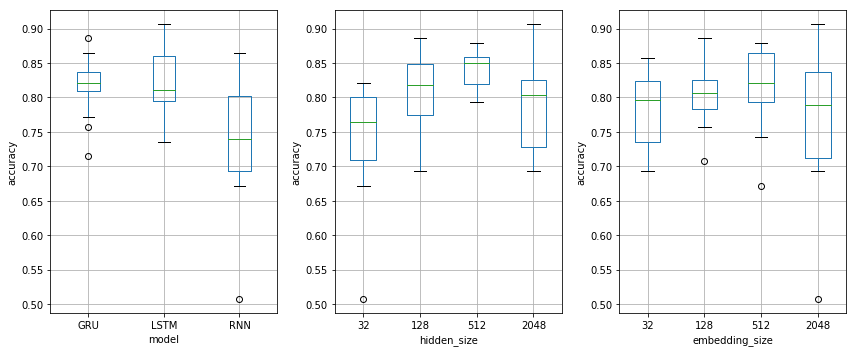

In [76]:
df = pd.DataFrame([{**k, 'accuracy': np.mean(v['accuracy']), 'model': str(k['model'].__name__)} for k,v in all_evals])
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
for ax, (k, _) in zip(axes, model_options):
    df.boxplot(column=['accuracy'], by=k, ax=ax)
    ax.set_title('')
    ax.set_ylabel('accuracy')

plt.suptitle('')
plt.tight_layout()

## Conclusion

These experiments suggest that we should definitely be filtering the dataset for unit tests and other extra variation, although tokenization strategy does not seem to have a significant impact. For model parameters, we will use GRU or LSTM with the corresponding hidden/embedding sizes identified above.